# Alexandre HEYMANN & Pierre MARCHETTI

This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [2]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x156e5546190>)

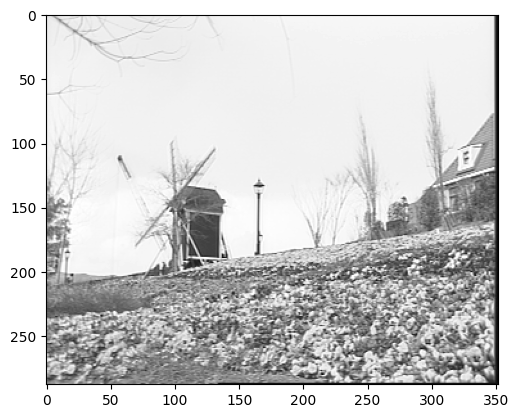

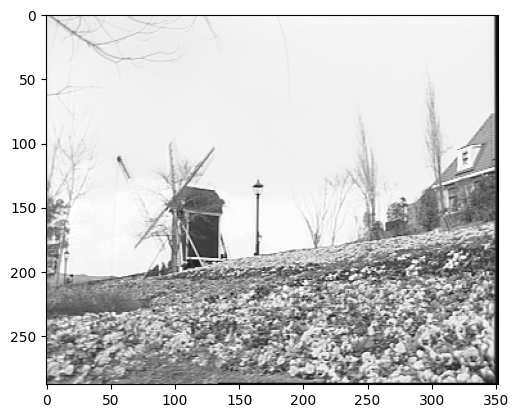

In [3]:
plt.figure(), plt.imshow(im1, cmap='gray')
plt.figure(), plt.imshow(im2, cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [4]:
brow = 16  # Number of rows per block
bcol = 16  # Number of columns per block
search_radius = 8  # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [22]:
# %%
def initVector(ref, cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """

    step = 8
    cont = 4*step

    REF = gaussian_filter(ref, 1.)  # Unclear how to set sigma
    CUR = gaussian_filter(cur, 1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step, cont +
              1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV = np.zeros(2)

    for globR in range(-cont, cont):
        for globC in range(-cont, cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step,
                     cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD < SSDMIN:
                SSDMIN = SSD
                pV[0] = globR
                pV[1] = globC

    return pV

# %%


def computePredictor(r, c, brow, bcol, mvf, ref, cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref, cur)

    elif r < brow:  # First row
        pV = mvf[r, c-bcol, :]

    elif c < bcol:  # First column
        pV = mvf[r-brow, c, :]

    else:  # Inside
        if c >= np.shape(mvf)[1]-bcol:  # Last column
            vC = mvf[r-brow, c-bcol, :]

        else:  # Not the last column
            vC = mvf[r-brow, c+bcol, :]

        vA = mvf[r, c-bcol, :]
        vB = mvf[r-brow, c, :]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp, axis=1)

    pV = pV.ravel()

    return pV


# %%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)  # To avoid border effect

    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol
    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))

    h, w = cur.shape

    # Non-regularized search
    if lamb == 0:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, np.shape(cur)[0], brow):
            for c in range(0, np.shape(cur)[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+brow]  # Block

                # Initialization:
                bestD = None

                costMin = np.inf

                Rbest = None

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(-search, search):
                    # rcol = candidate displacement vector over the rows
                    for drow in range(-search, search):
                        R = ref_extended[r + extension - drow: r + extension - drow +
                                         brow, c + extension - dcol: c + extension - dcol + bcol]
                        cost = np.sum((B - R) ** 2)
                        d = np.array([drow, dcol])

                        if cost < costMin:  # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d

                # Once the loop is over, save the best row displacement field
                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = bestD[0]
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = bestD[1]
                prediction[r:r+brow, c:c+bcol] = Rbest.reshape(brow, bcol)

    else:  # Regularized search
        # for each block in the current image, find the best corresponding block in the reference image
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, h, brow):
            for c in range(0, w, bcol):
                # current block selection
                B = cur[r: r + brow, c: c + bcol]  # Block

                # Initializations
                bestD = None  # Meilleur déplacement

                costMin = np.inf

                Rbest = None

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)

                # Loop on candidate vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(-search, search):
                    # rcol = candidate displacement vector over the rows
                    # rcol = candidate displacement vector over the rows
                    for drow in range(-search, search):
                        R = ref_extended[r + extension - drow: r + extension - drow +
                                         brow, c + extension - dcol: c + extension - dcol + bcol]
                        d = np.array([drow, dcol])
                        # distance euclidienne
                        error = np.sqrt(np.sum((d - pV)**2))
                        # here, encore the REGULARIZED cost function
                        cost = np.sum((B - R) ** 2) + lamb * error

                        if cost < costMin:  # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d

                # Once the loop is over, save the best row displacement field
                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = bestD[0]
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = bestD[1]
                prediction[r:r+brow, c:c+bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction

In [23]:
mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

### **Answers**

There are errors since the sky is a uniform region (errors with the arrows).

By changing the block size I don't see any effects on the results.


In [24]:
def displayMVF(I, mvf, subsamp):

    row, col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp, 0:col:subsamp, 0]
    vectCol = mvf[0:row:subsamp, 0:col:subsamp, 1]

    # Determine vector origins
    X, Y = np.meshgrid(np.arange(0, col, subsamp), np.arange(0, row, subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I, cmap='gray')

    plt.quiver(X, Y, vectCol, -vectRow)

    return

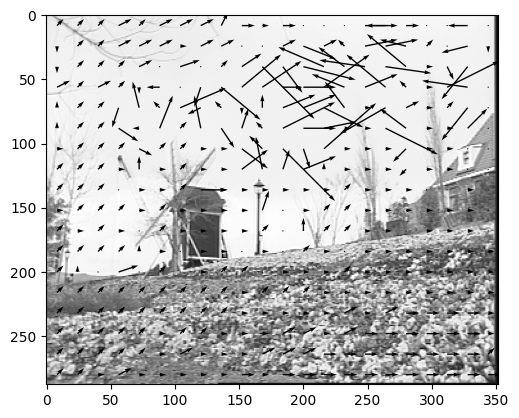

In [25]:
displayMVF(im1, mvf_ssd, brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In [26]:
def fracMc(ref, mvf, outofbound=20):

    [rows, cols] = np.shape(ref)

    # Initial coordinates, used to infer the new coordinates
    mc_c, mc_r = np.meshgrid(np.arange(cols), np.arange(rows))

    mc_r_tmp = mc_r + mvf[:, :, 0]   # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:, :, 1]  # Column coordinates, after the movement

    extension = outofbound
    ref = cv2.copyMakeBorder(ref, extension, extension, extension,
                             extension, cv2.BORDER_REFLECT)  # Padded image

    # Row coordinates, after the movement (in the padded image)
    mc_r = mc_r_tmp + extension
    # Column coordinates, after the movement (in the padded image)
    mc_c = mc_c_tmp + extension

    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(
        cols+2*extension), np.arange(rows+2*extension))  # Original coordinates, in the padded image

    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1], 2))
    points[:, 0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:, 1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols, 2))
    points_inter[:, 0] = mc_c.reshape(rows*cols)
    points_inter[:, 1] = mc_r.reshape(rows*cols)

    # Perform the interpolation after the movement
    motcomp = griddata(points, values, points_inter)

    motcomp = motcomp.reshape(rows, cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x156e79282b0>)

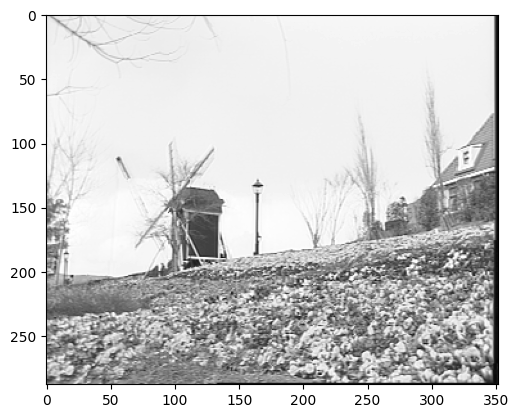

In [27]:
mc_ssd = fracMc(im1, mvf_ssd)
plt.figure(), plt.imshow(mc_ssd, cmap='gray')

### **Answers**

It seems that there are less errors than before. Indeed, the errors were located in the uniform region (sky).

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

In [28]:
def PSNR(im1, im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    mse = np.mean((im1 - im2) ** 2)
    if (mse == 0):
        return 100
    max_pixel = float(255.0)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

In [29]:
psnr_ssd = PSNR(im2, mc_ssd)
print(psnr_ssd)

22.70609398219703


In [30]:
PSNR(im1, im2)

18.786509322935075

### **Answers**

The PSNR is the ratio between the maximum possible power of an image and the power of noise that affects its quality.

We have a better PSNR between images 1 and 2 than between image 2 and the motion-compensated image, which is consistent because we have reduced the difference between images 1 and 2.

When increasing or decreasing the search window, the result varies little.

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [31]:
def computePredictor(r, c, brow, bcol, mvf, ref, cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref, cur)

    elif r < brow:  # First row
        pV = mvf[r, c-bcol, :]

    elif c < bcol:  # First column
        pV = mvf[r-brow, c, :]

    else:  # Inside
        if c >= np.shape(mvf)[1]-bcol:  # Last column
            vC = mvf[r-brow, c-bcol, :]

        else:  # Not the last column
            vC = mvf[r-brow, c+bcol, :]

        vA = mvf[r, c-bcol, :]
        vB = mvf[r-brow, c, :]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp, axis=1)

    pV = pV.ravel()

    return pV

# %%


def initVector(ref, cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """

    step = 8
    cont = 4*step

    REF = gaussian_filter(ref, 1.)  # Unclear how to set sigma
    CUR = gaussian_filter(cur, 1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step, cont +
              1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV = np.zeros(2)

    for globR in range(-cont, cont):
        for globC in range(-cont, cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step,
                     cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD < SSDMIN:
                SSDMIN = SSD
                pV[0] = globR
                pV[1] = globC

    return pV
# %%


def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)

    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol

    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))
    h, w = ref.shape

    # Non-regularized search
    if lamb == 0.:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, h, brow):
            for c in range(0, w, bcol):
                # current block selection
                B = cur[r: r + brow, c: c + bcol]  # Block

                # Initialization:
                bestD = None  # Meilleur déplacement

                costMin = np.inf

                Rbest = None

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(-search, search):
                    # rcol = candidate displacement vector over the rows
                    for drow in range(-search, search):

                        R = ref_extended[r + extension - drow: r + extension - drow +
                                         brow, c + extension - dcol: c + extension - dcol + bcol]
                        cost = np.sum(np.abs(B - R))
                        d = np.array([drow, dcol])

                        if cost < costMin:  # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = bestD[0]
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = bestD[1]
                prediction[r:r+brow, c:c+bcol] = Rbest.reshape(brow, bcol)

    else:  # Regularized search
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, h, brow):
            for c in range(0, w, bcol):
                # current block selection
                B = cur[r: r + brow, c: c + bcol]  # Block

                # Initializations
                bestD = None  # Meilleur déplacement

                costMin = np.inf

                Rbest = None

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)

                # Loop on candidate vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(-search, search):
                    # rcol = candidate displacement vector over the rows
                    for drow in range(-search, search):

                        R = ref_extended[r + extension - drow: r + extension - drow +
                                         brow, c + extension - dcol: c + extension - dcol + bcol]

                        d = np.array([drow, dcol])
                        error = np.sqrt(np.sum((d - pV)**2))
                        # here, encore the REGULARIZED cost function
                        cost = np.sum(np.abs(B - R)) + lamb * error

                        if cost < costMin:  # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = bestD[0]
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = bestD[1]
                prediction[r:r+brow, c:c+bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction

In [32]:
mvf_sad, prediction = me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

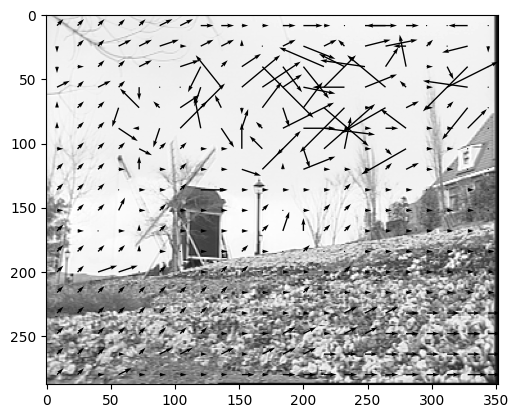

In [33]:
displayMVF(im1, mvf_sad, brow)

### **Answers**

I don't see too much of a change between the two metrics. Maybe less outliers with the last one.

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x156e7a27670>)

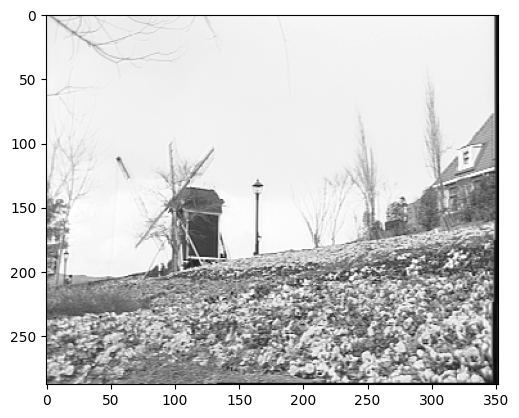

In [34]:
mc_sad = fracMc(im1, mvf_sad)
plt.figure(), plt.imshow(mc_sad, cmap='gray')

In [35]:
psnr_sad = PSNR(im2, mc_sad)
print(psnr_sad)

22.624556595489405


### **Answers**

Result is very similar so we can't really say with metric is better than the other one.

Impact of block size : better when diminishing the size.

## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

In [36]:
lambdas = np.logspace(-4, 4, 8)
for lamb in lambdas:
    mvf_ssd, prediction = me_ssd(im2,
                                 im1,
                                 brow,
                                 bcol,
                                 search_radius,
                                 lamb=lamb)
    mc_ssd = fracMc(im1, mvf_ssd)
    print(f"PSNR for lambda = {lamb} : {PSNR(im2, mc_ssd)}")

PSNR for lambda = 0.0001 : 22.70609398219703
PSNR for lambda = 0.0013894954943731374 : 22.70609287653944
PSNR for lambda = 0.019306977288832496 : 22.706046193475817
PSNR for lambda = 0.2682695795279725 : 22.70585234127999
PSNR for lambda = 3.727593720314938 : 22.704855330789833
PSNR for lambda = 51.79474679231202 : 22.663050121238655
PSNR for lambda = 719.6856730011514 : 21.89589764888231
PSNR for lambda = 10000.0 : 21.14010816417288


### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

In [37]:
lambdas = np.logspace(-10, 4, 8)
for lamb in lambdas:
    mvf_sad, prediction = me_sad(im2,
                                 im1,
                                 brow,
                                 bcol,
                                 search_radius,
                                 lamb=lamb)
    mc_sad = fracMc(im1, mvf_sad)
    print(f"PSNR for lambda = {lamb} : {PSNR(im2, mc_sad)}")

PSNR for lambda = 1e-10 : 22.62455683662119
PSNR for lambda = 1e-08 : 22.62455683662119
PSNR for lambda = 1e-06 : 22.62455683662119
PSNR for lambda = 0.0001 : 22.62455683662119
PSNR for lambda = 0.01 : 22.614402479936405
PSNR for lambda = 1.0 : 22.566956865323764
PSNR for lambda = 100.0 : 21.14010816417288
PSNR for lambda = 10000.0 : 21.14010816417288


# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [38]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x156e7bcb8e0>)

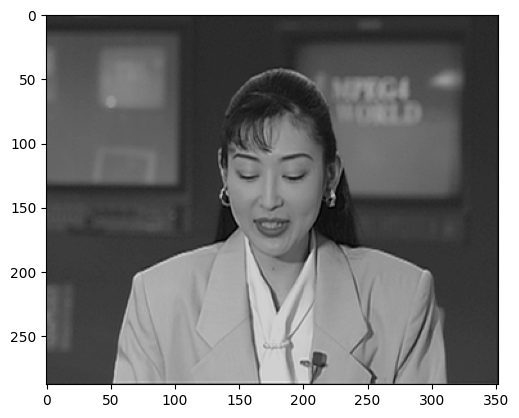

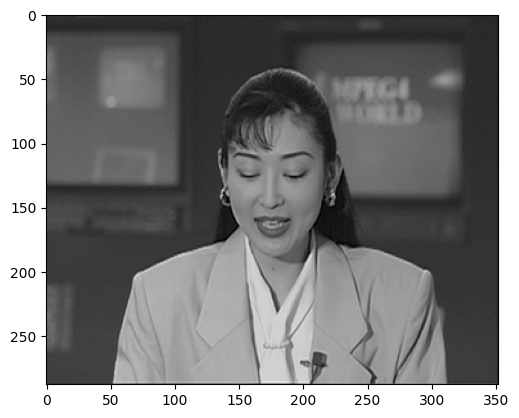

In [39]:
plt.figure(), plt.imshow(im1, cmap='gray')
plt.figure(), plt.imshow(im2, cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [40]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims(
        (1./12.)*np.array([-1., 8., 0., -8., 1.]), axis=1).T
    fx = convolve2d(im1, kernel1D, 'same')
    fy = convolve2d(im1, kernel1D.T, 'same')
    ft = convolve2d(im1, 0.25*np.ones((2, 2)), 'same') + \
        convolve2d(im2, -0.25*np.ones((2, 2)), 'same')
    fx = -fx
    fy = -fy

    return fx, fy, ft


# %%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100, blur=1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1, blur)
    im2 = gaussian_filter(im2, blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1 = np.array(
        [[1./12., 1./6., 1./12.], [1./6., 0., 1./6.], [1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, 'same')
        vAvg = convolve2d(v, kernel_1, 'same')

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(uAvg*fx + vAvg*fy+ft) / \
            (alpha**2 + np.linalg.norm(fx+fy+ft)**2)
        v = vAvg - fx*(uAvg*fx + vAvg*fy+ft) / \
            (alpha**2 + np.linalg.norm(fx+fy+ft)**2)

    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0
    return u, v

In [47]:
brow = 16
bcol = 16
search_radius = 13

mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=0)

alpha = 100
ite = 100

uInitial = mvf_ssd[:, :, 1]
vInitial = mvf_ssd[:, :, 0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite, blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

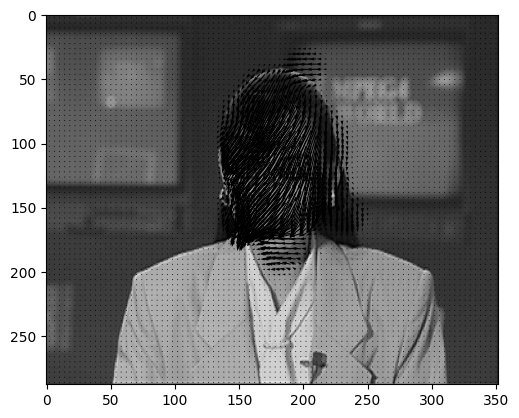

In [48]:
mvf_hs = np.zeros((np.shape(v)[0], np.shape(v)[1], 2))
mvf_hs[:, :, 0] = v
mvf_hs[:, :, 1] = u
displayMVF(im1, mvf_hs, 4)

mc_hs = fracMc(im1, mvf_hs)
psnr_hs = PSNR(im2, mc_hs)

In [45]:
psnr_hs

41.260569121891294